#  Notebook file for LJ13 Evaluation & Visualization


In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from vgs.models.modules_temb import FCNet_temb
from vgs.models.vgsampler import ValueGradientSampler
from vgs.models.modules import invariant_wrapper
device = "cuda:0"

## Import energy model

In [9]:
from vgs.energy.DW4 import MultiDoubleWellPotential
n_particles = 4
n_dim = 2
total_dim = n_particles * n_dim
dw4_model = MultiDoubleWellPotential()
dw4_model.to(device)

energy = lambda x: -dw4_model.unnorm_log_prob(x).float().to(device)

No Ground truth sample provided


## Load checkpoint

In [10]:
# Use invariant value network
in_dim = n_particles * (n_particles - 1) // 2
value_net = invariant_wrapper(n_particles, n_dim, net = FCNet_temb(in_dim=in_dim, out_dim=1, hidden_dim=512, t_emb_dim=512, activation='relu')).to(device)

n_step = 30
sampler = ValueGradientSampler(value_net, n_step=n_step, sample_shape=(total_dim,),
                               s2_schedule='quad',
                               s2_start=0.1,
                               s2_end=1e-4,
                               alpha_method='ve',
                               D_effective=(n_particles-1)*n_dim,
                               scale_with_D=True,
                               ).to(device)

sampler_ckpt = "../checkpoints/DW4_ckpt_quad_0.1_1e-4.pth"
sampler.load_state_dict(torch.load(sampler_ckpt))

<All keys matched successfully>

In [11]:
"""
Import the test data for visualization
"""
from utils.particle_utils import remove_mean

data = np.load("../vgs/particle_data/DW4/test_DW4.npy", allow_pickle=True)

data = remove_mean(torch.tensor(data), n_particles, n_dim)

print(f"Test data shape: {data.shape}")


Test data shape: torch.Size([8192, 8])


In [12]:
from vgs.eval.metrics import wasserstein, Energy_TVD_particle, Atomic_TVD_particle

l_w2 = []
l_tvd_e = []
l_tvd_a = []
torch.manual_seed(0)
np.random.seed(0)
for _ in range(10):
    n_test = 2000
    samples = sampler.sample(n_test, device, energy=energy, final_noise=False)["sample"]
    samples = remove_mean(samples, n_particles, n_dim)
    index = np.random.choice(data.shape[0], n_test, replace=False)
    real_samples = data[index].to(device)

    w2 = wasserstein(samples, real_samples)
    tvd_e = Energy_TVD_particle(samples, real_samples, energy)
    tvd_a = Atomic_TVD_particle(samples, real_samples, n_particles, n_dim)
    l_w2.append(w2)
    l_tvd_e.append(tvd_e)
    l_tvd_a.append(tvd_a)

print("Wasserstein distance: ", np.mean(l_w2), np.std(l_w2))
print("Energy TVD: ", np.mean(l_tvd_e), np.std(l_tvd_e))
print("Atomic TVD: ", np.mean(l_tvd_a), np.std(l_tvd_a))


Wasserstein distance:  1.610413189119057 0.027360680399378987
Energy TVD:  0.06639999999999999 0.008593020423576339
Atomic TVD:  0.05714166666666667 0.004399029248974522


In [13]:
n_vis = data.shape[0]
samples = sampler.sample(n_vis, device, energy=energy, final_noise=False)["sample"]
samples = remove_mean(samples, n_particles, n_dim)
real_samples = data.to(device)

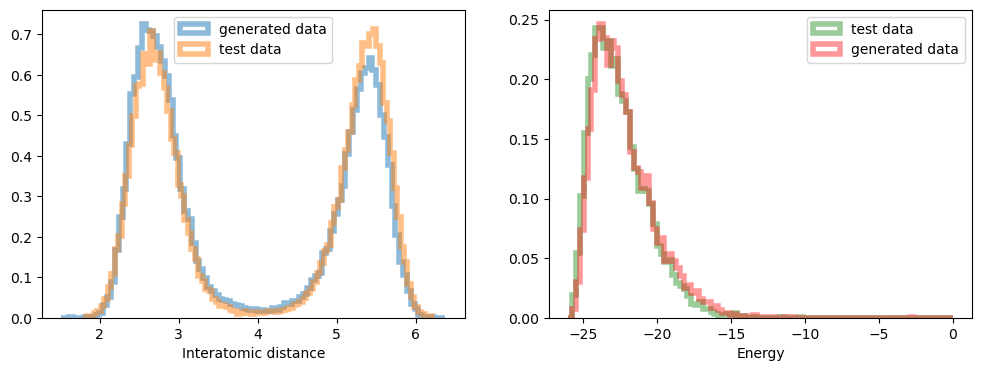

In [14]:
# Used the same code as in the DEM repository "dem/energies/multi_double_well_energy.py"
from vgs.eval.metrics import interatomic_dist
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

dist_samples = interatomic_dist(samples, n_particles, n_dim).detach().cpu()
dist_test = interatomic_dist(real_samples, n_particles, n_dim).detach().cpu()

axs[0].hist(
    dist_samples.view(-1),
    bins=100,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
)
axs[0].hist(
    dist_test.view(-1),
    bins=100,
    alpha=0.5,
    density=True,
    histtype="step",
    linewidth=4,
)
axs[0].set_xlabel("Interatomic distance")
axs[0].legend(["generated data", "test data"])

energy_samples = energy(samples).squeeze(-1).detach().detach().cpu()
energy_test = energy(real_samples).squeeze(-1).detach().detach().cpu()

min_energy = -26
max_energy = 0

axs[1].hist(
    energy_test.cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(min_energy, max_energy),
    color="g",
    histtype="step",
    linewidth=4,
    label="test data",
)
axs[1].hist(
    energy_samples.cpu(),
    bins=100,
    density=True,
    alpha=0.4,
    range=(min_energy, max_energy),
    color="r",
    histtype="step",
    linewidth=4,
    label="generated data",
)
axs[1].set_xlabel("Energy")
axs[1].legend()
plt.show()